In [1]:
import xml.etree.ElementTree as ET
import os
import cv2
from  matplotlib import pyplot as plt
%matplotlib inline

In [2]:
with_mask_index = 0
without_mask_index = 0
resize = 128

for xml_file in os.listdir(os.path.join('source', 'annotations')):
    try:
        tree = ET.ElementTree(file=os.path.join('source', 'annotations', xml_file))
        image = cv2.imread(os.path.join('source', 'images', tree.find('filename').text))
        for ob in tree.findall('object'):
            bndbox = ob.find('bndbox')
            label = ob.find('name').text
            ymin = int(bndbox.find('ymin').text)
            xmin = int(bndbox.find('xmin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            if label == 'with_mask':
                if with_mask_index >= 1000:
                    continue
                index = with_mask_index
            elif label == 'without_mask':
                if without_mask_index >= 1000:
                    continue
                index = without_mask_index
                
            pic = image[ymin:ymax, xmin:xmax]
            pic = cv2.resize(pic, (resize,resize))
            cv2.imwrite(os.path.join('./data', label, str(index) + '.jpg'), pic)
            
            if label == 'with_mask':
                with_mask_index += 1
            elif label == 'without_mask':
                without_mask_index += 1
            
    except Exception as e:
        print(e)
    
print('with_mask_index: ', with_mask_index)
print('without_mask_index:', without_mask_index)

with_mask_index:  1000
without_mask_index: 717


In [12]:
import numpy as np
import random
import time
random.seed(int(time.time()))
def build_data(path):
    datas = []
    for file_path in os.listdir(path):
        datas.append(cv2.imread(os.path.join(path, file_path)) / 255.0)
    return datas


train_x = []
train_y = []
val_x = []
val_y = []

data = build_data(os.path.join('./data', 'with_mask'))
random.shuffle(data)
train_x += data[:int(len(data) * 0.7)]
train_y += [1] * int(len(data) * 0.7)
val_x += data[int(len(data) * 0.7):]
val_y += [1] * (len(data) - int(len(data) * 0.7))

data = build_data(os.path.join('./data', 'without_mask'))
random.shuffle(data)
train_x += data[:int(len(data) * 0.7)]
train_y += [0] * int(len(data) * 0.7)
val_x += data[int(len(data) * 0.7):]
val_y += [0] * (len(data) - int(len(data) * 0.7))

train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout

In [15]:
def get_model(shape):

    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model



model = get_model(train_x[0].shape)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_x, train_y, batch_size=32, validation_data=(val_x, val_y), epochs=10, shuffle=True)

Train on 1002 samples, validate on 432 samples
Epoch 1/10
1002/1002 [==============================] - 20s 20ms/step - loss: 0.4470 - accuracy: 0.8403 - val_loss: 0.2820 - val_accuracy: 0.9352
Epoch 2/10
1002/1002 [==============================] - 19s 19ms/step - loss: 0.1431 - accuracy: 0.9561 - val_loss: 0.1006 - val_accuracy: 0.9769
Epoch 3/10
1002/1002 [==============================] - 19s 19ms/step - loss: 0.1026 - accuracy: 0.9701 - val_loss: 0.0984 - val_accuracy: 0.9745
Epoch 4/10
1002/1002 [==============================] - 19s 19ms/step - loss: 0.0970 - accuracy: 0.9691 - val_loss: 0.1791 - val_accuracy: 0.9491
Epoch 5/10
1002/1002 [==============================] - 19s 19ms/step - loss: 0.0968 - accuracy: 0.9721 - val_loss: 0.1307 - val_accuracy: 0.9537
Epoch 6/10
1002/1002 [==============================] - 19s 19ms/step - loss: 0.0840 - accuracy: 0.9741 - val_loss: 0.1195 - val_accuracy: 0.9606
Epoch 7/10
1002/1002 [==============================] - 20s 20ms/step - loss:

[[0.9997949]]


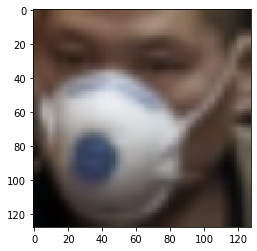

In [21]:
image = val_x[20]
print(model.predict(np.expand_dims(image, axis=0)))
image = (image * 255.0).astype(int)
image = image[:,:,::-1] 
plt.imshow(image)
plt.show()

In [22]:
model.save_weights('mask.h5')